<h1> Don't Overfit </h1>
<br>
<br>
This report is the process that was untaken to create the model that was entered into the Kaggle competition,"Don't Overfit".The premise of the competition is stated below : 
<br>
<br>
<blockquote>"we have 20,000 rows of continuous variables, and a mere handful of training samples. Once again, we challenge you not to overfit. Do your best, model without overfitting, and add, perhaps, to your own legend."</blockquote>
<br>
<br>
The basic structure of this report will consist of :
<ul>
    <li> Exploratory Data Analysis</li>
    <li> Exploring the Features Correlation</li>
    <li> Creating a scoring function <li>
    <li> Basic Modelling </li>
    <li> Experimenting with the model - Feature selection / adding polynomial features </li>
</ul>

<h2> Exploratory Data Analysis</h2>

From an initial look, we can see the following information :
<ul> 
    <li> Dataset contains Interval Data.</li>
    <li> It has 300 features and only 250 records </li>
    <li> There is an imbalance in the classification of 16/25 </li>
    <li> There is no missing Data</li>
</ul>

In [79]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sn

In [80]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

label = train["target"]
feature = train.iloc[:,2:]


The information below shows example records of the dataframe, a brief description of the dataframe , the balance of the binary classifications and any missing data.


In [81]:
print("Dataframe")
print(feature.head(2))
print("----------------------------------------------------")
print("Info")
print(feature.info())
print("----------------------------------------------------")
print("Label Count")
print(label.value_counts())
print("----------------------------------------------------")
print("Missing Data")
print(feature.isnull().any().any())


Dataframe
       0      1      2      3      4      5      6      7      8      9  \
0 -0.098  2.165  0.681 -0.614  1.309 -0.455 -0.236  0.276 -2.246  1.825   
1  1.081 -0.973 -0.383  0.326 -0.428  0.317  1.172  0.352  0.004 -0.291   

   ...      290    291    292    293    294    295    296    297    298    299  
0  ...    0.867  1.347  0.504 -0.649  0.672 -2.097  1.051 -0.414  1.038 -1.065  
1  ...   -0.165 -1.695 -1.257  1.359 -0.808 -1.624 -0.458 -1.099 -0.936  0.973  

[2 rows x 300 columns]
----------------------------------------------------
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 586.0 KB
None
----------------------------------------------------
Label Count
1.0    160
0.0     90
Name: target, dtype: int64
----------------------------------------------------
Missing Data
False


The graphs below show the Std and mean of the dataframe as well the medium, Quartiles and outliers of first 25 columns.

Text(0.5, 0, 'Columns')

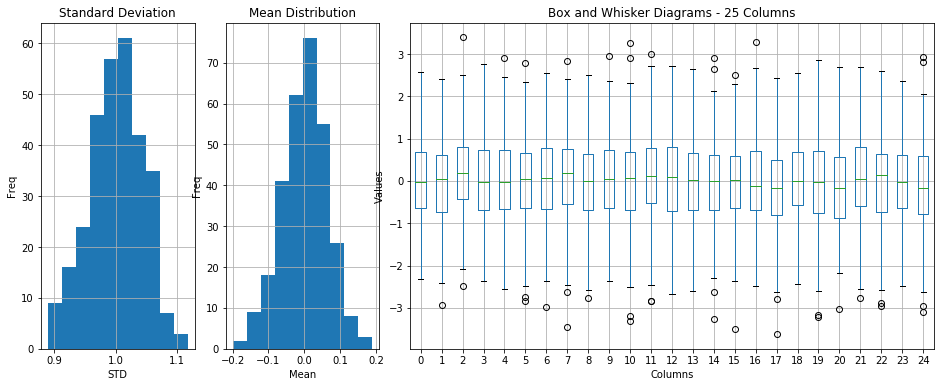

In [82]:
fig = plt.figure(figsize=(16,6))
g = gs.GridSpec(1,5,fig)
ax = fig.add_subplot(g[0,0])
ax1 = fig.add_subplot(g[0,1])
ax2 = fig.add_subplot(g[0,2:])

feature.std().hist(ax=ax)
ax.set_title("Standard Deviation")
ax.set_ylabel("Freq")
ax.set_xlabel("STD")

feature.mean().hist(ax=ax1)
ax1.set_title("Mean Distribution")
ax1.set_ylabel("Freq")
ax1.set_xlabel("Mean")

feature.iloc[:,:25].boxplot(ax=ax2)
ax2.set_title("Box and Whisker Diagrams - 25 Columns")
ax2.set_ylabel("Values")
ax2.set_xlabel("Columns")

From the graphs above, we can see that :
<ul>
    <li> Std is between the min(0.89) and max(1.117) but most frequency differences are around the 1.0 mark.</li>
    <li> Mean is  0 +/- 0.15 with min (-0.2) and max(0.19)</li>
    <li> The quartiles and median are within 0.8 of each other within the first 25 columns</li>  
</ul>
This suggests that the data collected is very similar and greater EDA must be untaken. 
<h2> Exploring the Features Correlations</h2>

Text(0.5, 0, 'Corr')

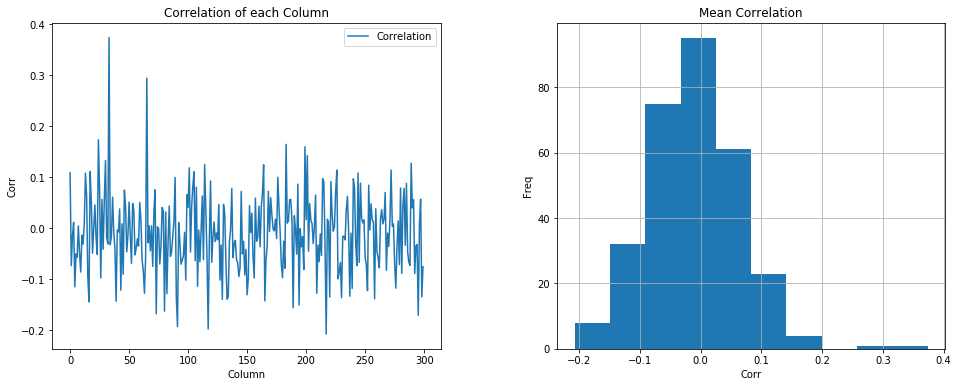

In [83]:
df_corr = feature.apply(lambda x: x.corr(label))
df_corr = df_corr.reset_index()
fig = plt.figure(figsize=(16,6))
g = gs.GridSpec(1,2,fig)
ax = fig.add_subplot(g[0,0])
ax1 = fig.add_subplot(g[0,1])

df_corr.plot(ax=ax)
ax.legend(labels=["Correlation"])
ax.set_title("Correlation of each Column")
ax.set_ylabel("Corr")
ax.set_xlabel("Column")
df_corr.hist(ax=ax1)
ax1.set_title("Mean Correlation")
ax1.set_ylabel("Freq")
ax1.set_xlabel("Corr")

The correlation between the features and target label is fairly low with the mean correlation being 0. However, the graphs do indicate some features having a stronger correlation than others and therefore feature selection may be a useful tool.

<h1> Exploring with different Classifers</h1>

Due to the high number of features but low sample group. I will first examine logistic regression and use that as a bench mark while exploring other classifiers.  

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV ,cross_val_score
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Due to the unknown units that the features are in, a standardization process will need to be done. A KDE plot was done to check the distribution of the data. 

C:\Users\NJGaj\Anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


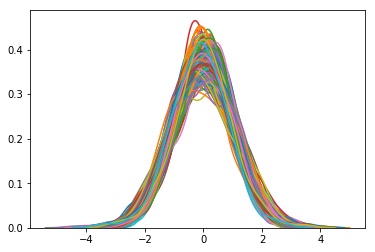

In [85]:
for column in feature.columns:
    sn.kdeplot(feature[column],legend =False)

With a Gaussian distribution found, a standard scaler was used to transform the features. 

In [86]:

scaler = StandardScaler()
new_feature = scaler.fit_transform(feature)
test_feature = scaler.transform(test.iloc[:,1:])

<h1>Creating the Cross validation Scoring Function</h1>

In [54]:
def scores(X ,y, model):
    score = []
    results = cross_val_score(model, X, y, cv = 5, scoring = 'roc_auc')
    score.append(results)
    score_df = pd.DataFrame(score).T
    score_df.loc['mean'] = score_df.mean()
    score_df.loc['std'] = score_df.std()
    score_df= score_df.rename(columns={0:'roc_auc'})
    print(score_df.iloc[-2:,:])
    

<h1> Optimising the Classifiers </h1>

A GridSearch was then performed on the Logistic Regression model to optimise the classifier.  

In [87]:
clf = LogisticRegression(max_iter=4000)


param_grid = [
  {'class_weight' : ['balanced', None],'penalty': ['l1'], 'solver': ['liblinear', 'saga'],'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
  {'class_weight' : ['balanced', None],'penalty': ['l2'], 'solver': ['newton-cg','lbfgs'],'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
 {'class_weight' : ['balanced', None],'penalty': ['l2','l1'], 'solver': ['saga'],'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
 ]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='roc_auc')
grid_search.fit(feature, label)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8041666666666666
Best parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


The best parameters from the GridSearch were then used to make the first submission. 

In [93]:

model = LogisticRegression( C = 0.1, class_weight ='balanced', penalty = 'l1', solver = 'liblinear').fit(feature,label)

prediction = model.predict_proba(test_feature)

scores(feature,label,model)


       roc_auc
mean  0.813889
std   0.036605
[0.6737728  0.49435179 0.55718988 ... 0.35594443 0.80099988 0.23817368]


In [94]:



test["target"]= prediction[:,1]
submission = test[["id","target"]]
submission.to_csv("submission.csv",index=False)
del prediction

 <img src="2nd attempt.JPG" alt="Smiley face" height="840" width="840"> 

This model resulted in a place of 165. The next model that was experimented with was the Support Vector Machine Classifier. Again, a GridSearch was used to find most suitable parameters, and then those parameters were used to create a new submission. 

In [96]:
from sklearn import svm

In [97]:

param_grid2 =  [
    {'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
]
grid_search = GridSearchCV(SVC(), param_grid=param_grid2, cv=10, scoring='roc_auc')
grid_search.fit(feature, label)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


Best score: 0.7618055555555556
Best parameters: {'C': 1000, 'gamma': 1e-05, 'kernel': 'rbf'}


In [98]:
clf = SVC(C= 25, gamma = 0.001, kernel = 'sigmoid').fit(feature,label)
prediction2 = clf.predict(test_feature)
scores(feature,label,clf)


       roc_auc
mean  0.753125
std   0.050154


The submission of the SVM was lower in the ranking than the Logistic Regression model, and so further investigation revolved around the Logistic Regression model only.

<h1> Feature Selection </h1> 

There are a number of feature selection methods that could be used to select the features for our classifier. The Feature Selection methods that I will use is : 
<ul>
    <li>Recursive Feature Elimination</li>
    <li>Recursive Feature Elimination - Cross Validation</li>
    
</ul>

<h3>Recursive Feature Elimination </h3>
Recursive Feature Elimination fits the model onto the data. This process then obtains the importance of each feature and recursively drops the feature with the least coefficient or importance until it finds the selection with the best number of features.

In [99]:
from sklearn.feature_selection import RFE

rfr_grid =  [5,10,15,25, 50, 75, 100, 125, 150, 175, 200 ,225,250,275]

for feature_num in rfr_grid :
    selector = RFE(model, feature_num, step=1)
    selector = selector.fit(feature, label)
    new_features =  selector.transform(feature)
    new_test_feature = selector.transform(test_feature)
    print("Number of Features {}".format(feature_num))
    scores(feature,label,selector)

Number of Features 5
       roc_auc
mean  0.772222
std   0.033112
Number of Features 10
       roc_auc
mean  0.810069
std   0.037616
Number of Features 15
       roc_auc
mean  0.807639
std   0.034538
Number of Features 25
       roc_auc
mean  0.816319
std   0.037995
Number of Features 50
       roc_auc
mean  0.813889
std   0.036605
Number of Features 75
       roc_auc
mean  0.813889
std   0.036605
Number of Features 100
       roc_auc
mean  0.813889
std   0.036605
Number of Features 125
       roc_auc
mean  0.813889
std   0.036605
Number of Features 150
       roc_auc
mean  0.813889
std   0.036605
Number of Features 175
       roc_auc
mean  0.813889
std   0.036605
Number of Features 200
       roc_auc
mean  0.813889
std   0.036605
Number of Features 225
       roc_auc
mean  0.813889
std   0.036605
Number of Features 250
       roc_auc
mean  0.813889
std   0.036605
Number of Features 275
       roc_auc
mean  0.813889
std   0.036605


After finding out that a reduction of features can improve the classifier. The RFECV was used to try and find the best performing selection of features.

In [100]:
from sklearn.feature_selection import RFECV



model = LogisticRegression( C = 0.1, class_weight ='balanced', penalty = 'l1', solver = 'liblinear')

rfe = RFECV(model, step=1, cv=3,scoring='roc_auc')
fit = rfe.fit(feature, label)


new_features =  rfe.transform(feature)
new_test_feature = rfe.transform(test_feature)
    

    
rfe.fit(new_features,label)
prediction4 = rfe.predict(new_test_feature)
scores(feature,label,rfe)


test["target"]= prediction4
submission = test[["id","target"]]
submission.to_csv("submission4.csv",index=False)
del prediction4

       roc_auc
mean  0.780903
std   0.046525


This resulted in a lowering of the roc_auc score and so the 25 features that were selected in the RFE was submitted.
    


In [101]:
selector = RFE(model, 25, step=1)
selector = selector.fit(feature, label)
new_features =  selector.transform(feature)
new_test_feature = selector.transform(test_feature)

 
selector.fit(new_features,label)
prediction5 = selector.predict_proba(new_test_feature)


test["target"]= prediction5
submission = test[["id","target"]]
submission.to_csv("submission5.csv",index=False)
del prediction5


 <img src="5th attempt.JPG" alt="Smiley face" height="840" width="840"> 

The new model with the reduced features showed an improved the ranking . The decision was to experiment with the reduced model and see if clearer boundaries could be set.

<h1> Polynomial Features </h1> 

The aims of using polynomial features is that the the higher order terms will allows us to learn important decision boundaries that we wouldn't be able to find using simply the original features. 

In [102]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

poly_features = poly.fit_transform(new_features)
poly_test_features = poly.transform(new_test_feature)


In [103]:
model.fit(poly_features,label)
scores(poly_features,label,model)

       roc_auc
mean  0.795139
std   0.015055


When the new model was fitted with the polynornimal features, the results showed that this didn't improve the performance as it increased the overfitting. 

<h1> Next steps </h1>

The next step will be to do further research on how to avoid overfitting. I will investigate similar competitions and look at the process that the winners took to avoid overfitting with a high dimensional / low sample dataset.